## Author:
Zeguo Li
Thi Thanh Thu Le (Jane Le)
Kazi Zabir Tasnimul Hassan
Romel Cureg
## Date crated: 20 October 2023
This notebook creates and save machine learning models that forecast electricity demand. Using the Kaggle dataset Daily Electricity Price and Demand Data (https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia).<br>
<br>Input: complete_dataset.csv from the kaggle site
<br>Output: trained and tested models

### To use the library, please pip install the libraries documented in requirements.txt


### Import

In [17]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import time 
import warnings

### Load the dataset

In [2]:
fileName = 'complete_dataset.csv'
demand_dataset = pd.read_csv(fileName)

### Ignore warnings - consider checking this option in the future in debugging

In [12]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Exploratory Data Analysis
### First six row of the dataset

In [3]:
demand_dataset.head(6)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
5,2015-01-06,130672.485,31.282311,130672.485,31.282311,0.000,0.000000,0.000000,17.7,26.0,31.6,0.0,N,N


### Dataset shape

In [4]:
print(demand_dataset.shape)

(2106, 14)


### Check for missing values

In [5]:
demand_dataset.info()
print(demand_dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB
date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive      

From the result above, we can see that there are 3 entries with rainfall value missing, and 1 entry that misses solar_exposure value 
### Find out the row that contains missing value(s)

In [6]:
print(demand_dataset[demand_dataset.isnull().any(axis=1)])

            date      demand        RRP  demand_pos_RRP  RRP_positive  \
161   2015-06-11  143465.445  37.481829      143465.445     37.481829   
1060  2017-11-26  108717.875  83.114514      108717.875     83.114514   
1377  2018-10-09  116449.310  99.000749      116449.310     99.000749   
1378  2018-10-10  109551.080  73.539698      109551.080     73.539698   

      demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
161              0.0           0.0              0.0              5.7   
1060             0.0           0.0              0.0             19.4   
1377             0.0           0.0              0.0             16.1   
1378             0.0           0.0              0.0             10.1   

      max_temperature  solar_exposure  rainfall school_day holiday  
161              14.0             8.3       NaN          Y       N  
1060             28.3             NaN       3.4          Y       N  
1377             17.9             7.2       NaN          Y       N

### Check for duplicated entry(s)

In [7]:
print(demand_dataset.duplicated())
print("Number of duplicated entry is :", demand_dataset.duplicated().sum())

0       False
1       False
2       False
3       False
4       False
        ...  
2101    False
2102    False
2103    False
2104    False
2105    False
Length: 2106, dtype: bool
Number of duplicated entry is : 0


### Minimum and Maximum value of the demand feature

In [8]:
print("Minimum:",demand_dataset['demand'].min())
print("Maximum", demand_dataset['demand'].max())
print("Difference", demand_dataset['demand'].max() - demand_dataset['demand'].min())

Minimum: 85094.37499999999
Maximum 170653.84000000003
Difference 85559.46500000004


### Distribution of school_day and holiday

school_day
N     653
Y    1453
dtype: int64 


 holiday
N    2029
Y      77
dtype: int64


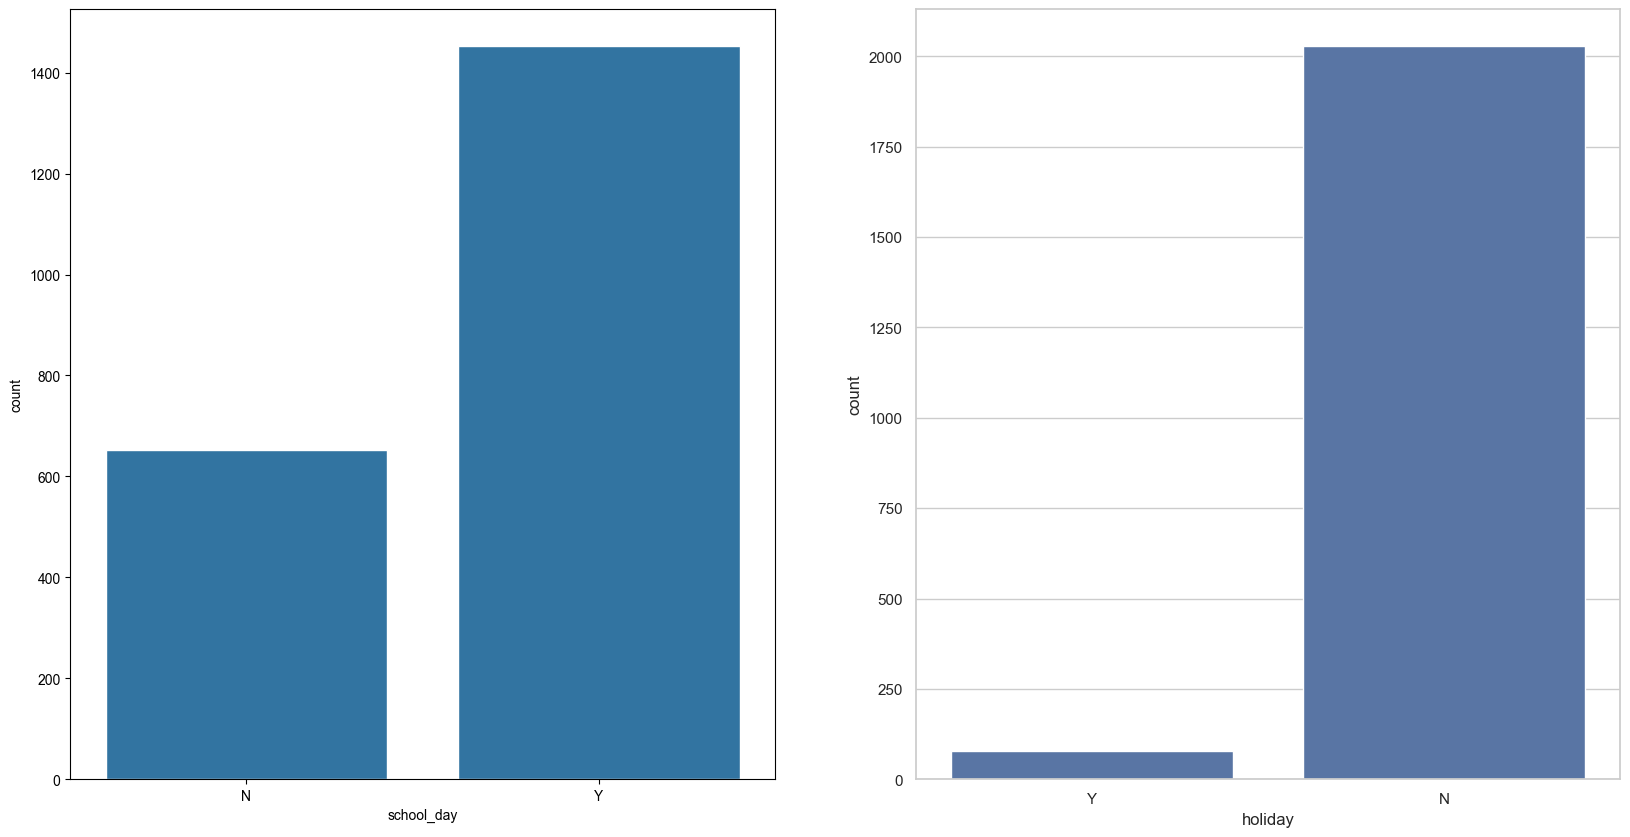

In [13]:
distSD = demand_dataset.groupby('school_day').size()
distHO = demand_dataset.groupby('holiday').size()
print(distSD, '\n'*3, distHO)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.set_theme(style = 'whitegrid')
sdDist = sns.countplot(x = demand_dataset['school_day'])
plt.subplot(1,2,2)
sns.set_theme(style = 'whitegrid')
hoDist = sns.countplot(x = demand_dataset['holiday'])
plt.show()

### Daily electricity demand and daily average RRP for electricity from 2015 to 2020

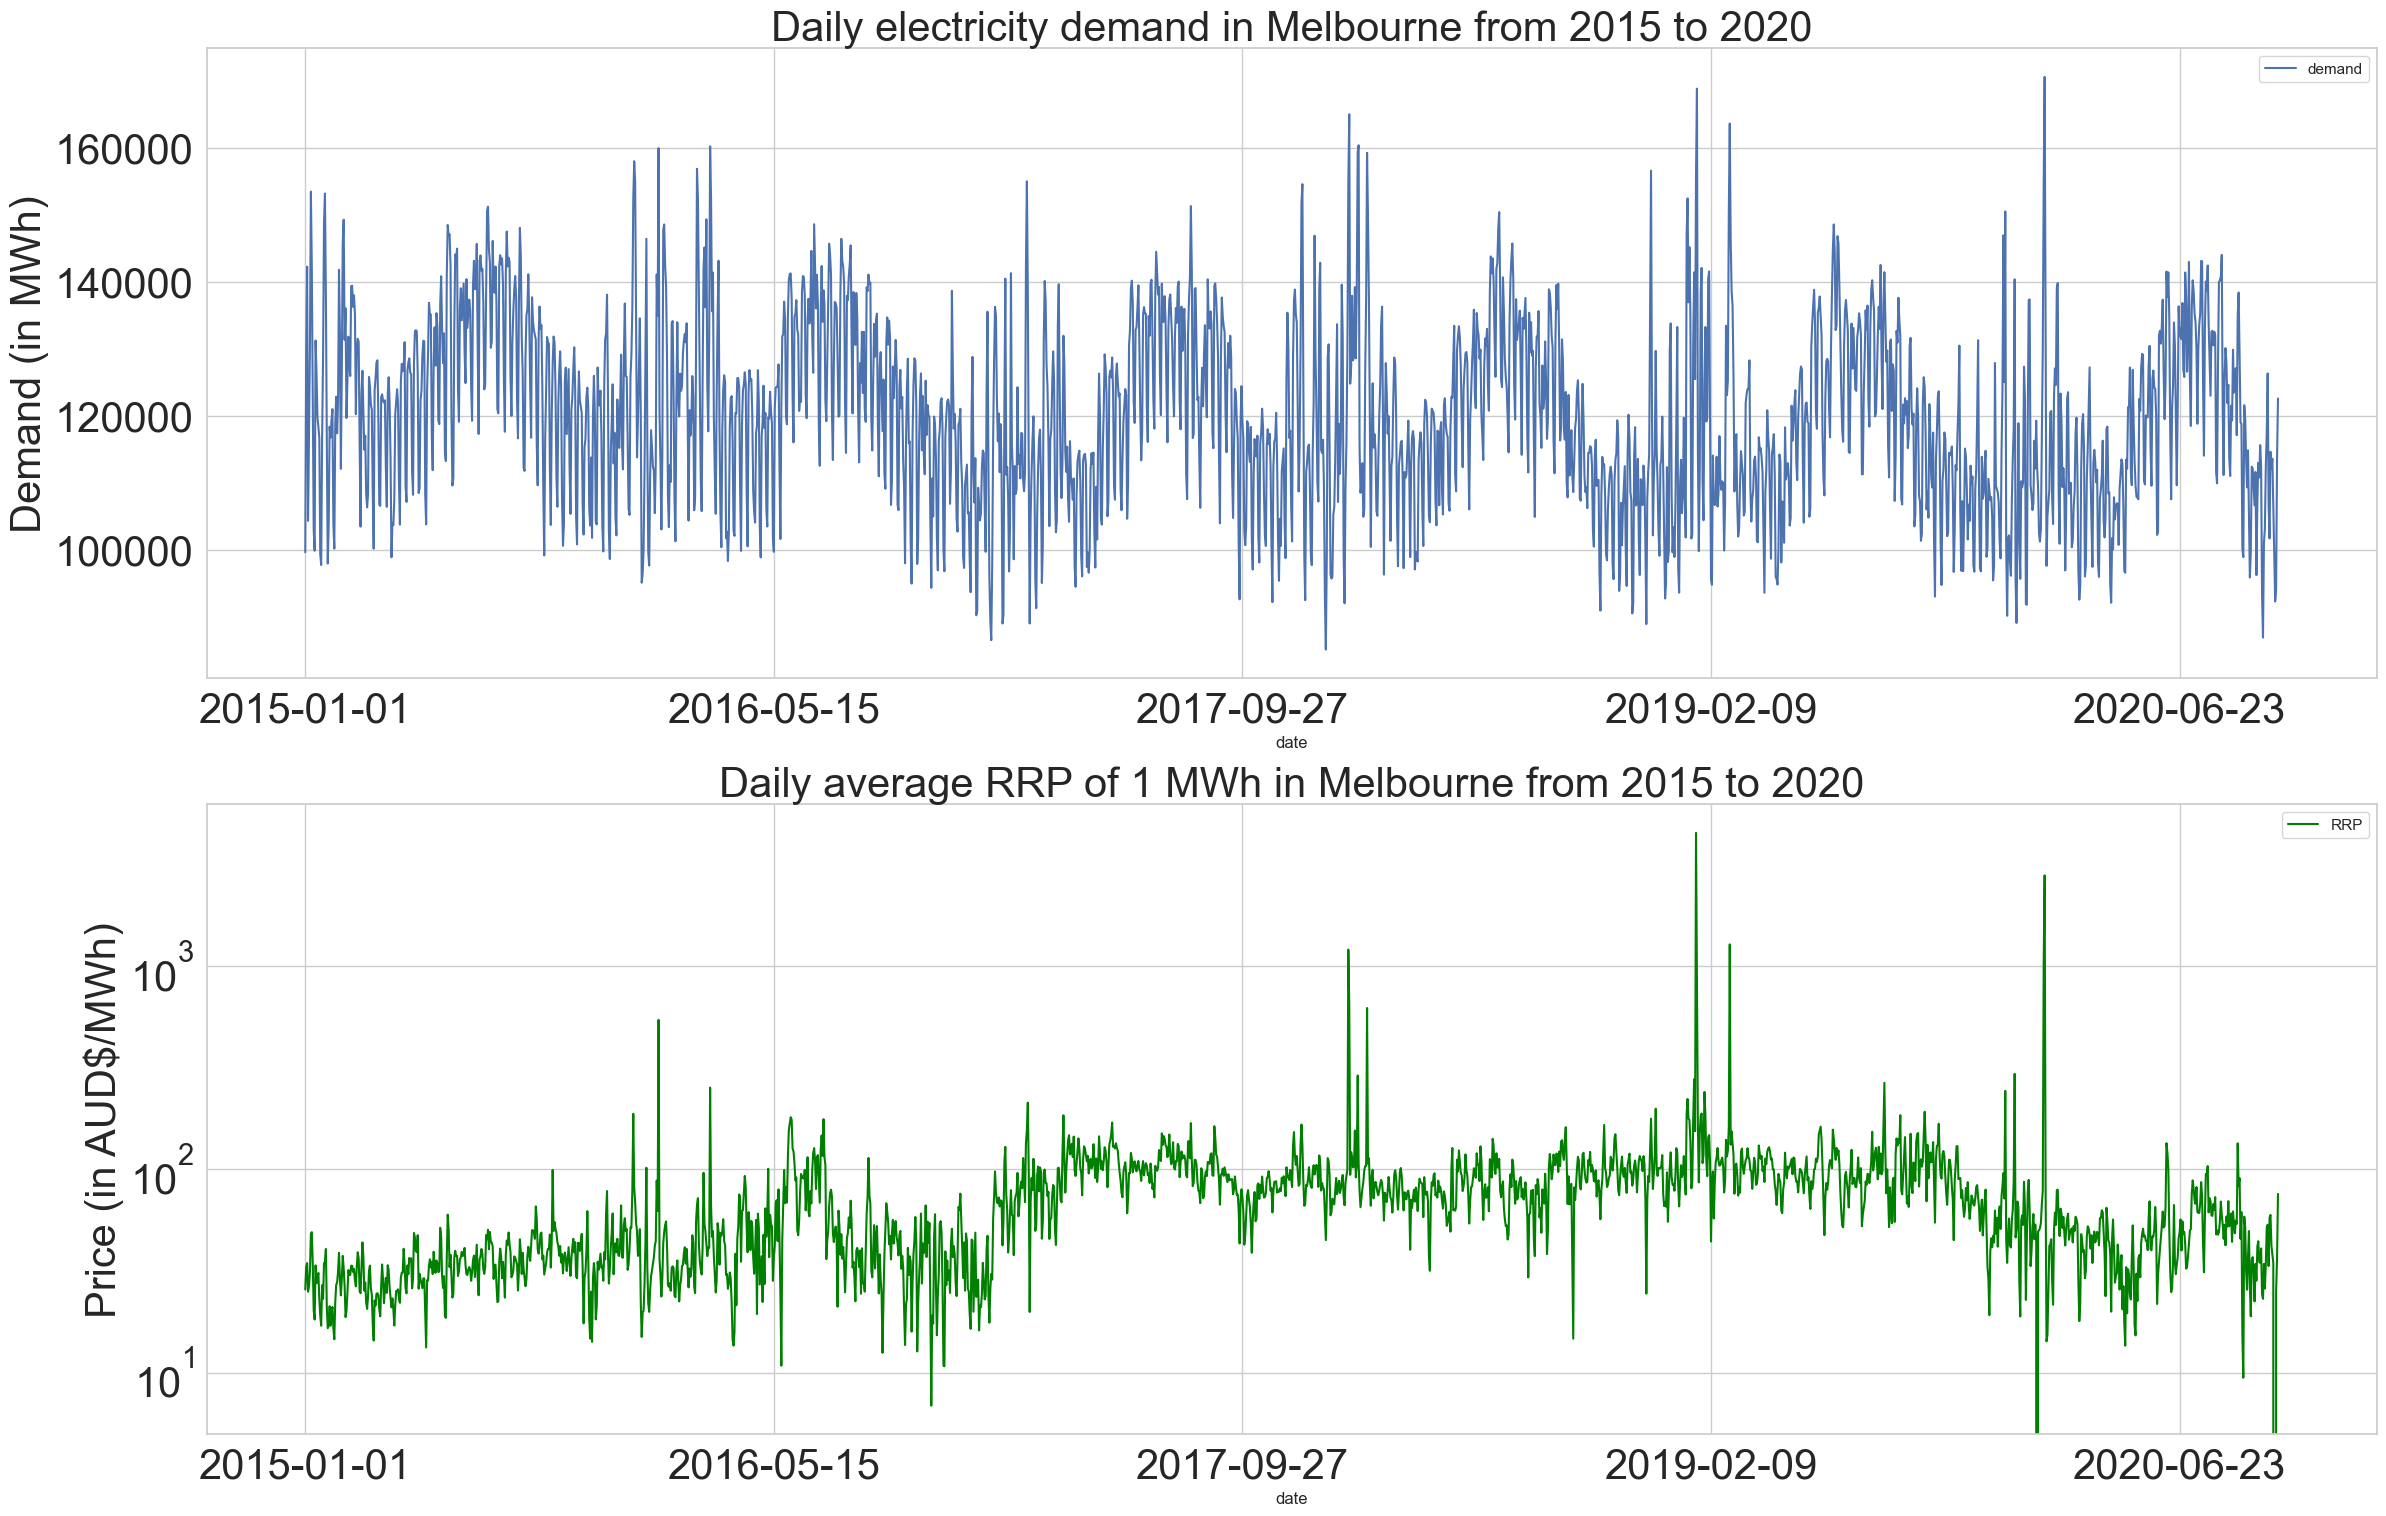

In [14]:
fig, ax = plt.subplots(2, 1, figsize = (28, 18))
ax[0].tick_params(labelsize=30)
demand_dataset.plot('date','demand', ax = ax[0])
ax[0].set_title("Daily electricity demand in Melbourne from 2015 to 2020", size = 30)
ax[0].set_ylabel("Demand (in MWh)", fontsize = 30)
# plt.grid(True)
demand_dataset.plot('date','RRP', color='green', ax = ax[1])
ax[1].tick_params(labelsize=30)
ax[1].set_title("Daily average RRP of 1 MWh in Melbourne from 2015 to 2020", size = 30)
ax[1].set_ylabel("Price (in AUD$/MWh)", fontsize = 30)
plt.yscale('log')
plt.show()

### Climate data

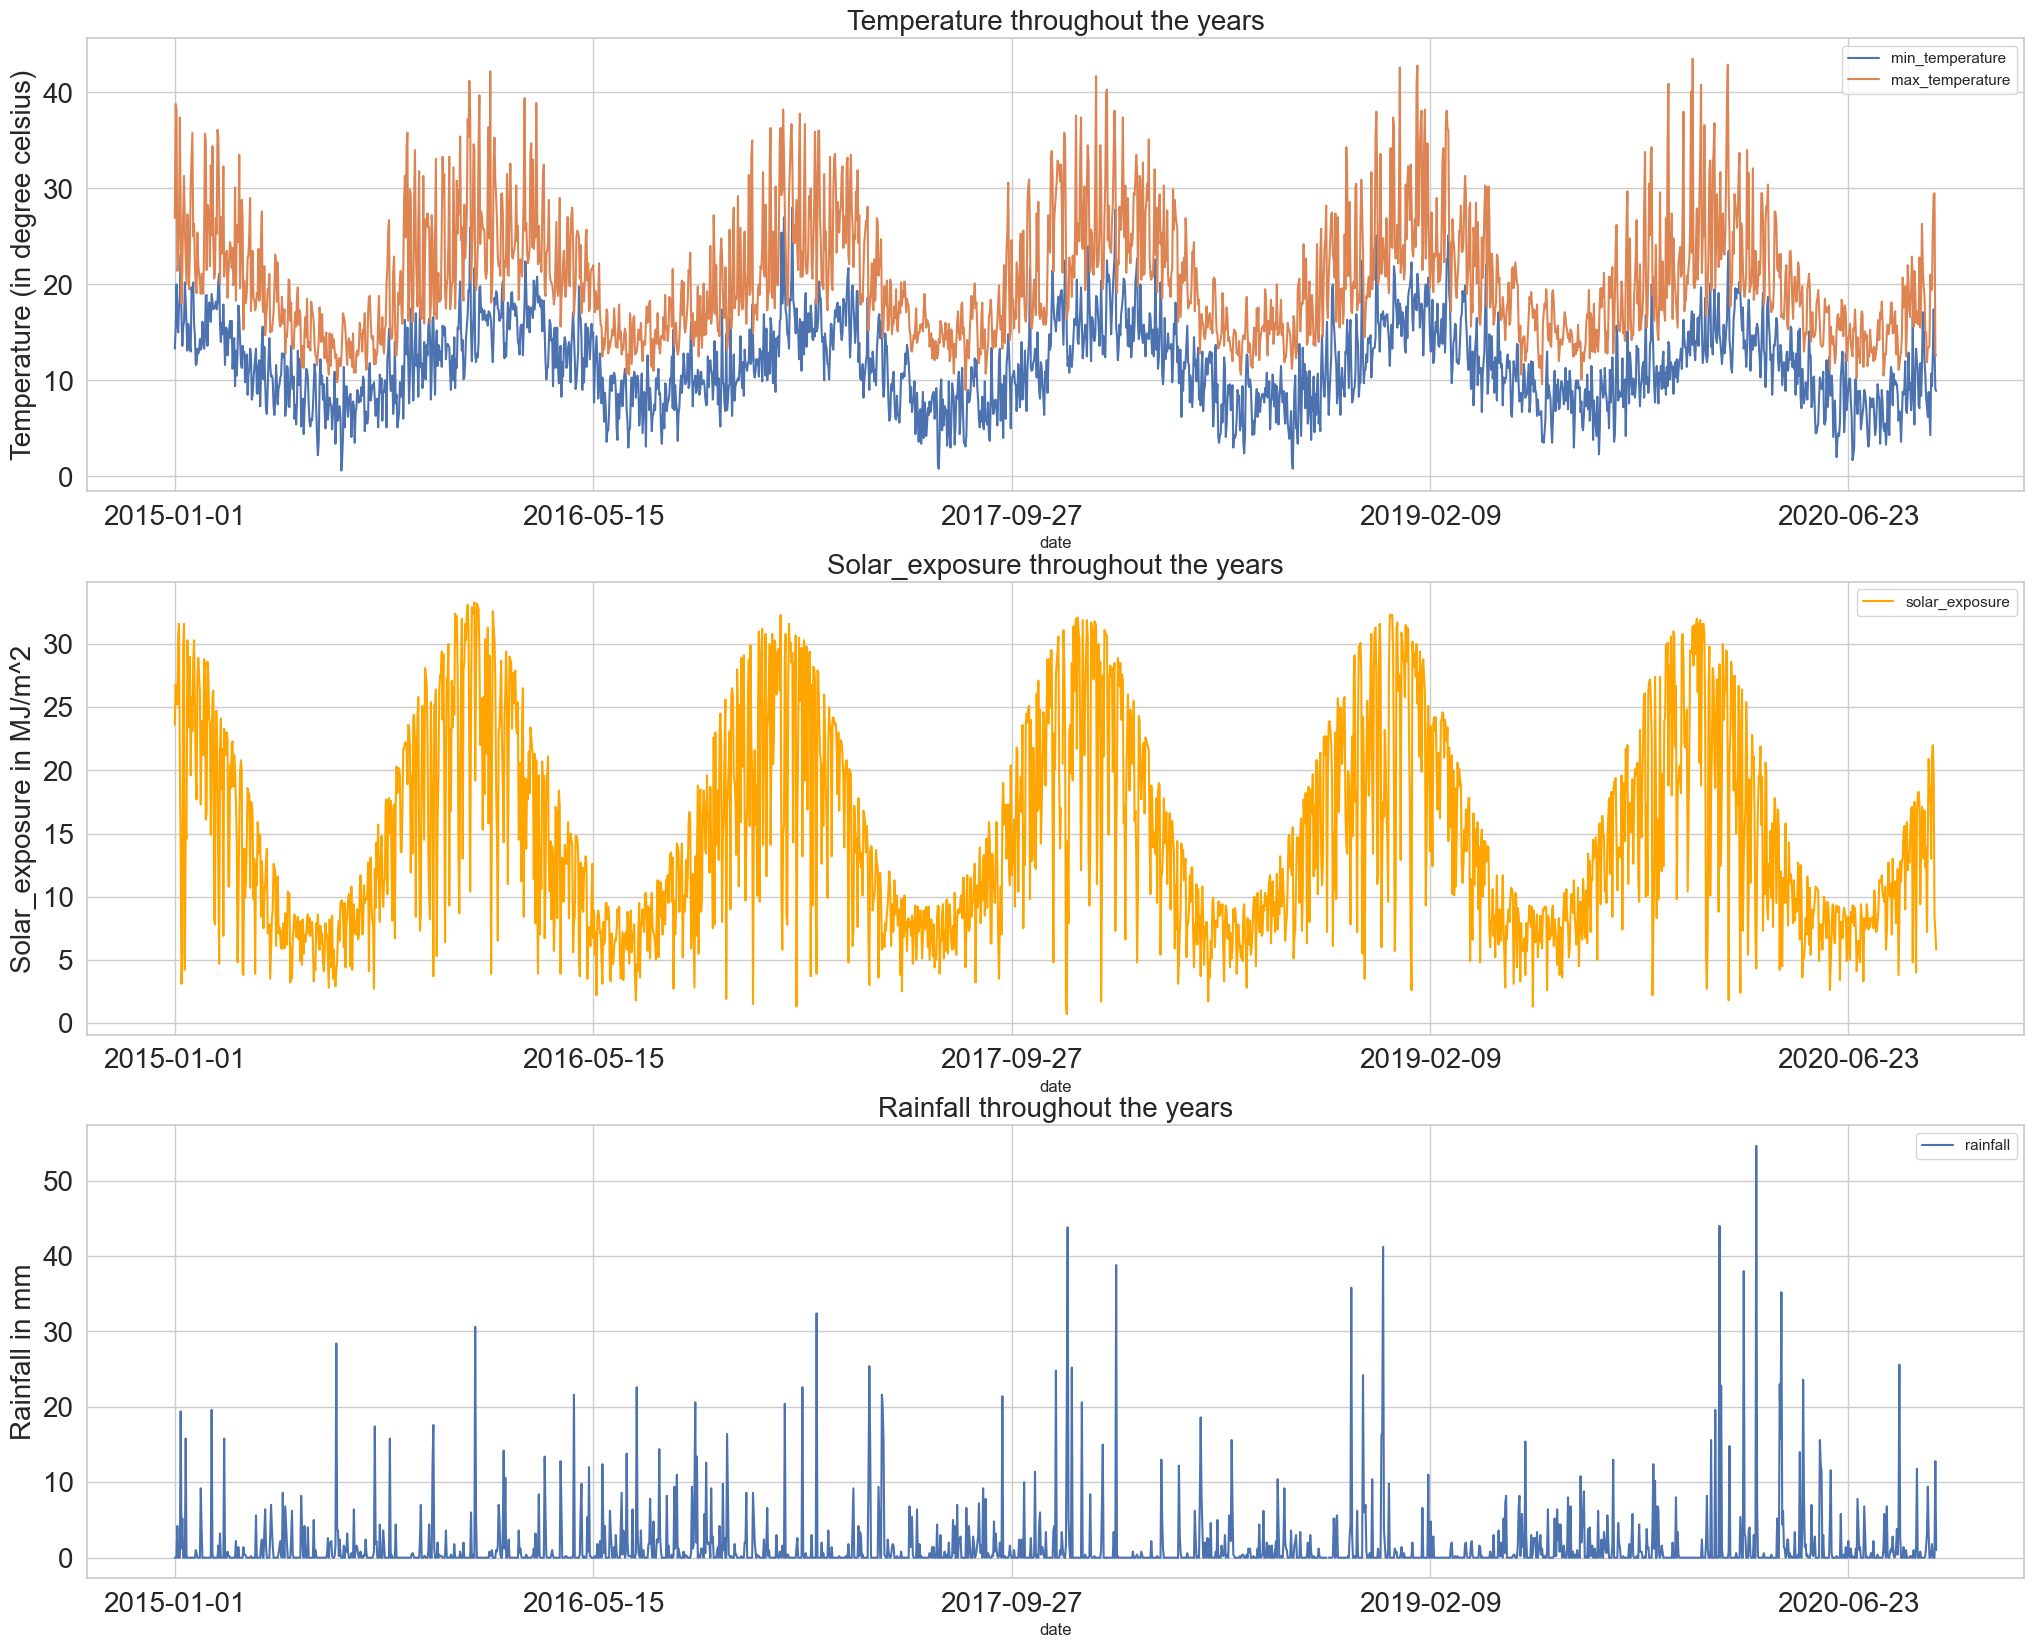

In [15]:
fig, ax = plt.subplots(3, 1, figsize = (25, 20))
demand_dataset.plot('date', ['min_temperature', 'max_temperature'], ax = ax[0])
ax[0].tick_params(labelsize=20)
ax[0].set_title("Temperature throughout the years", size = 20)
ax[0].set_ylabel("Temperature (in degree celsius)", fontsize = 20)
demand_dataset.plot('date', 'solar_exposure', ax = ax[1], color = 'orange')
ax[1].tick_params(labelsize=20)
ax[1].set_title("Solar_exposure throughout the years", size = 20)
ax[1].set_ylabel("Solar_exposure in MJ/m^2", fontsize = 20)
demand_dataset.plot('date', 'rainfall', ax = ax[2])
ax[2].tick_params(labelsize=20)
ax[2].set_title("Rainfall throughout the years", size = 20)
ax[2].set_ylabel("Rainfall in mm", fontsize = 20)
plt.show()

### Correlation Matrix

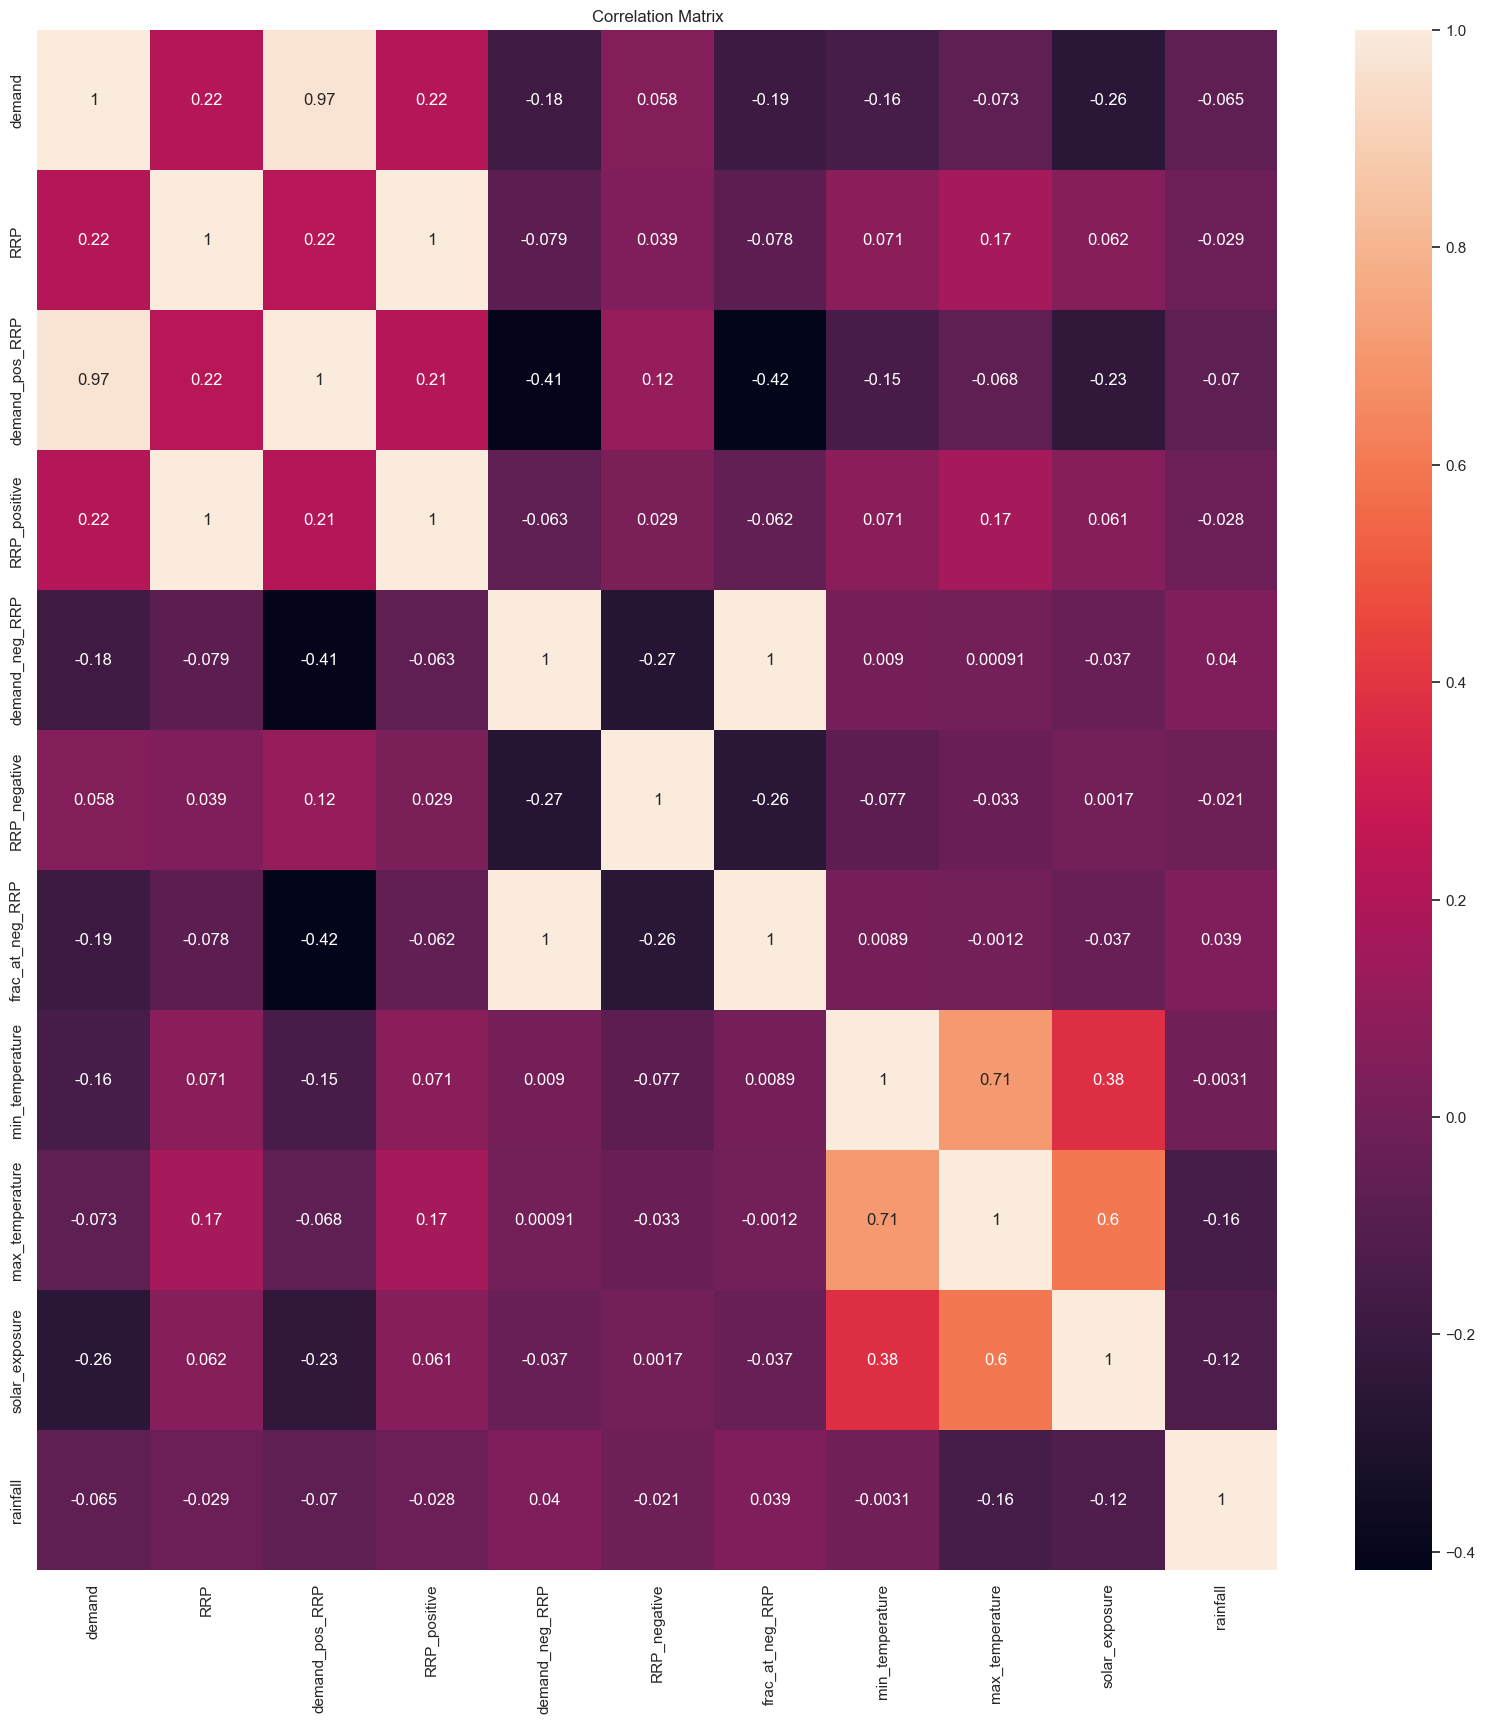

In [16]:
# Convert the data type of 'school_day' and 'holiday' into dummy variable for the heatmap
demand_dataset = pd.read_csv(fileName, index_col=0)
pd.to_datetime(demand_dataset.index)
demand_dataset['school_day'] = demand_dataset['school_day'].replace({'Y':1, 'N':0})
demand_dataset['holiday'] = demand_dataset['holiday'].replace({'Y':1, 'N':0})
demand_dataset[25:30]

# Heat map
heat_map, ax = plt.subplots(figsize=(20, 20)) #Set size of the heat map
sns.heatmap(demand_dataset.iloc[:, [0,1,2,3,4,5,6,7,8,9,10]].corr(), annot=True, ax = ax)
plt.title("Correlation Matrix")
plt.show()

### Seasonality and trend analysis of demand and RRP using seasonal_component with additive model (linear regression)

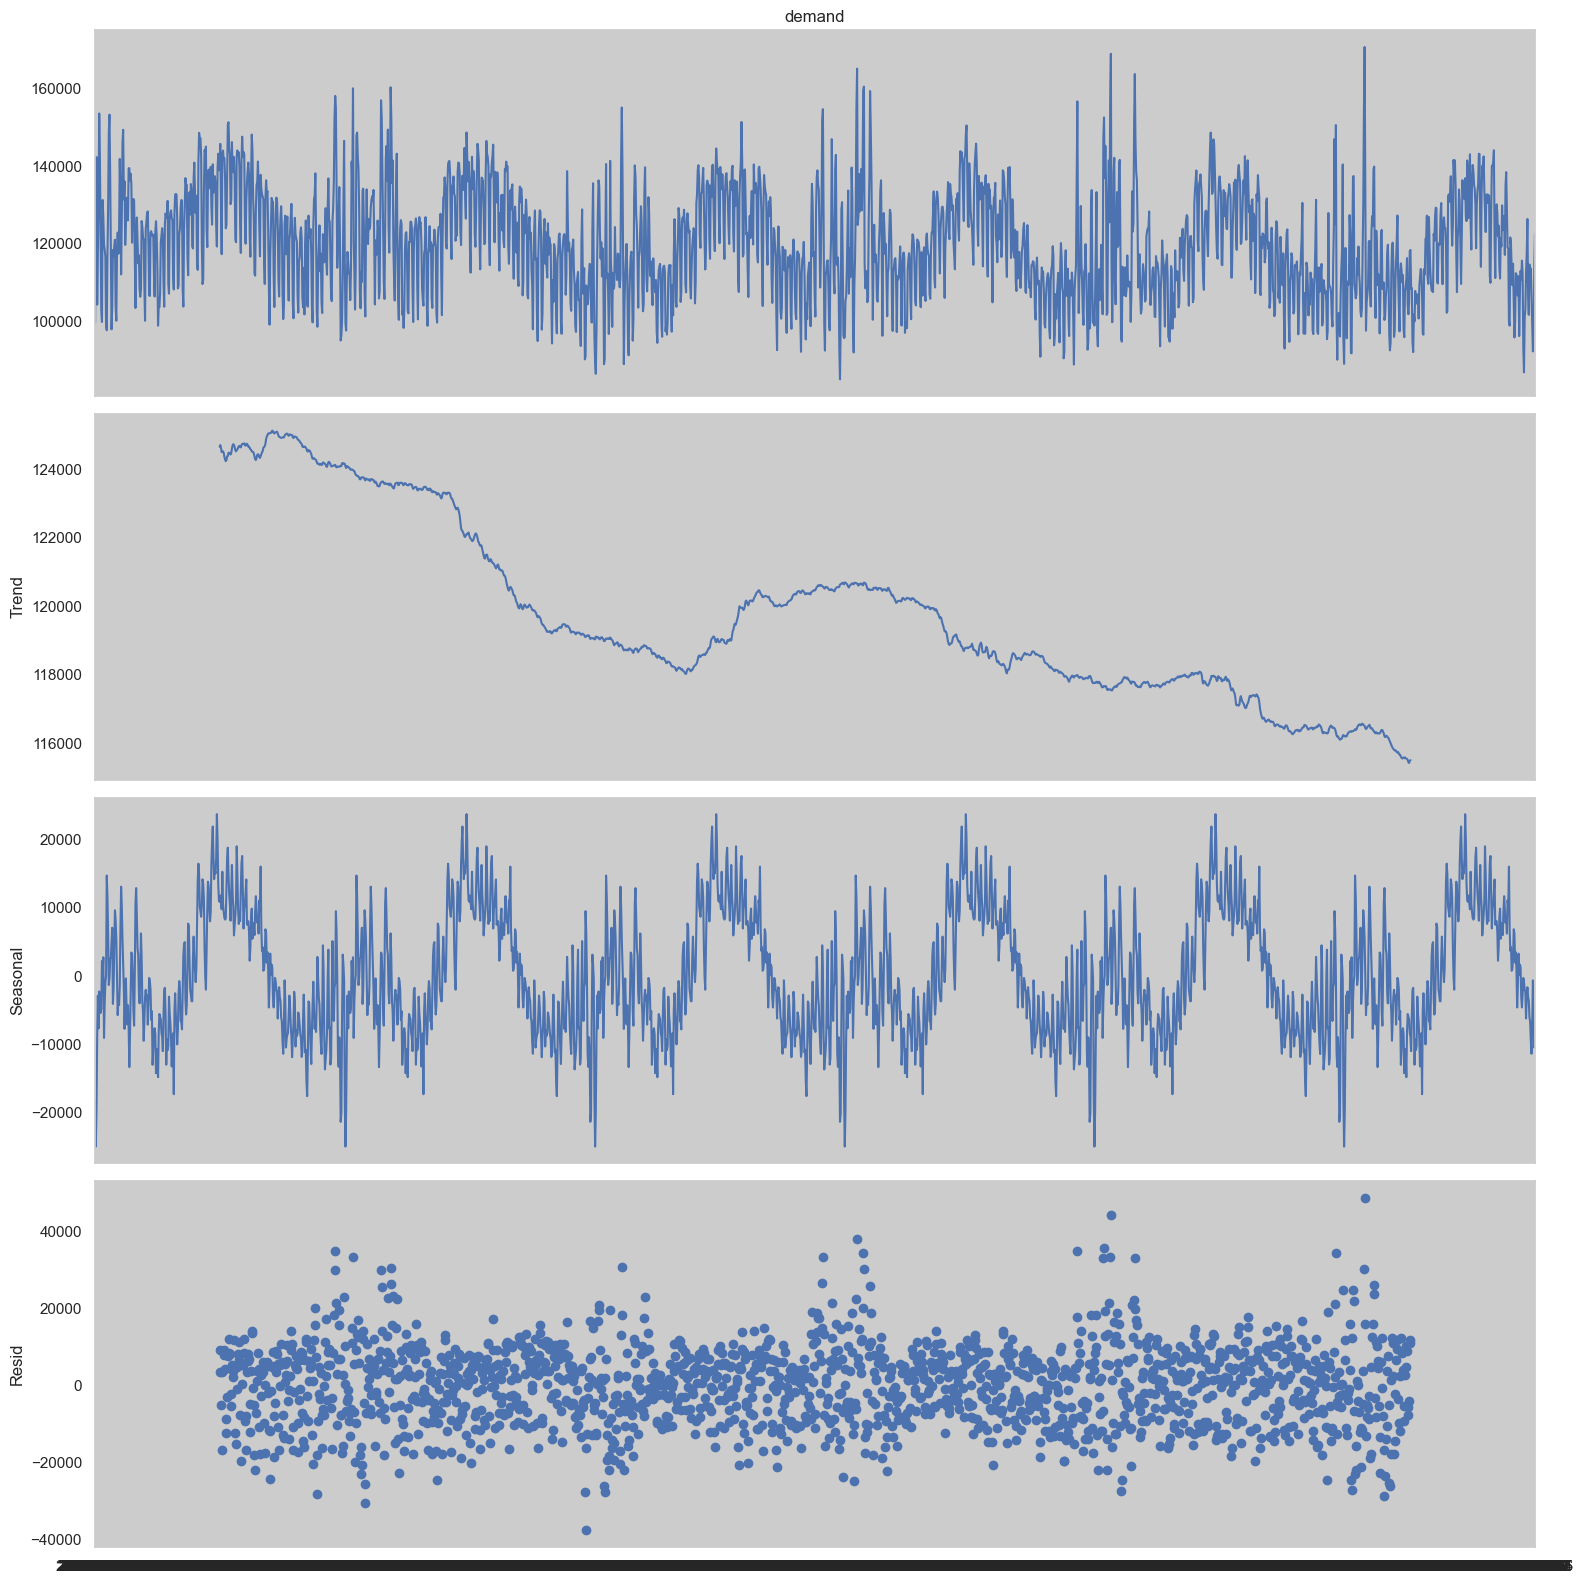

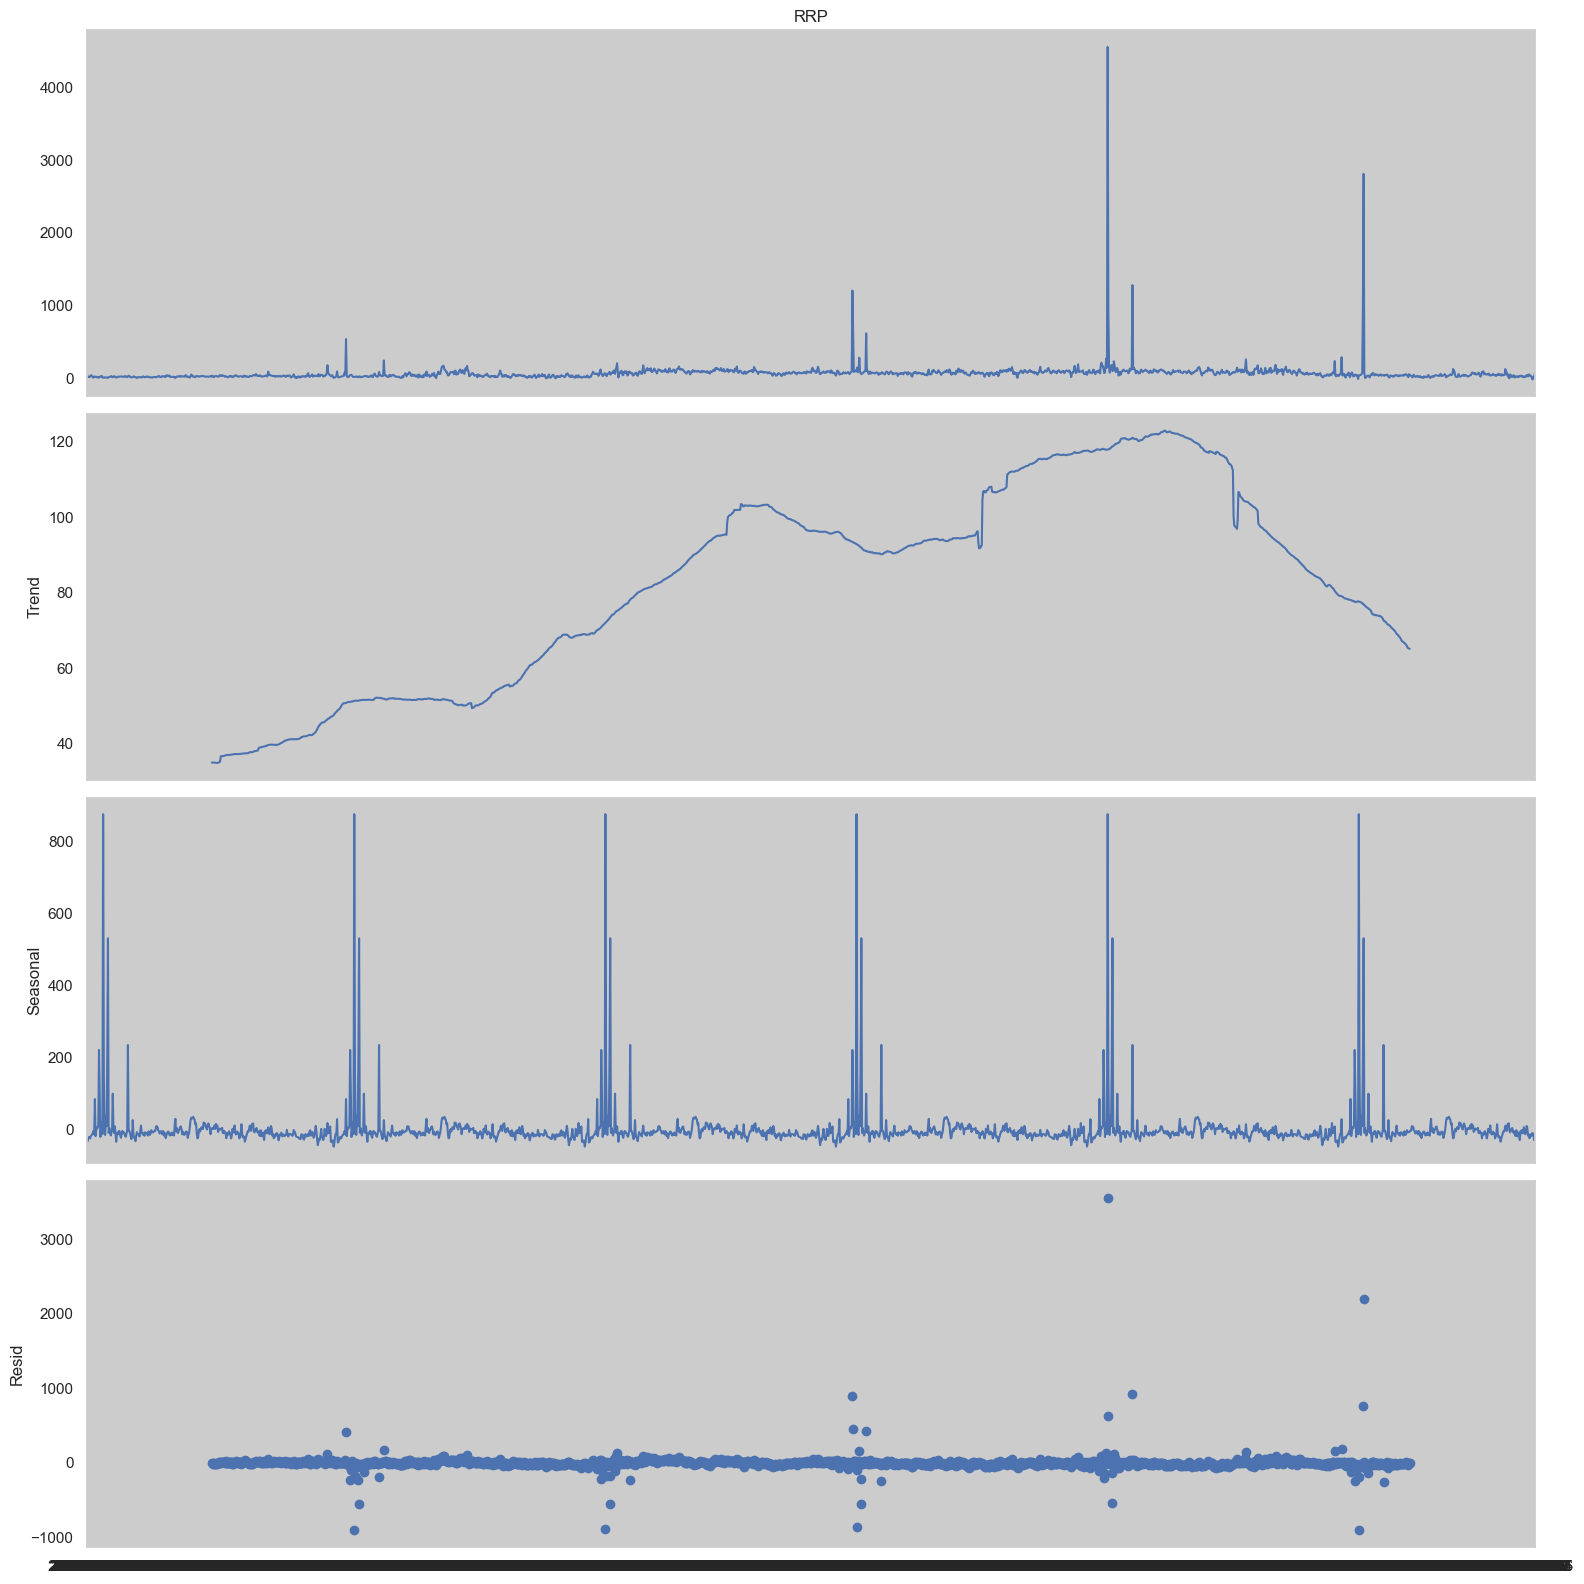

In [18]:
plt.rcParams["figure.figsize"] = (16, 16)
seasonal_decompose(demand_dataset['demand'], period=365, model='add').plot()
plt.show()
plt.rcParams["figure.figsize"] = (16, 16)
seasonal_decompose(demand_dataset['RRP'], period=365, model='add').plot()
plt.show()

### Outlier Analysis - Demand

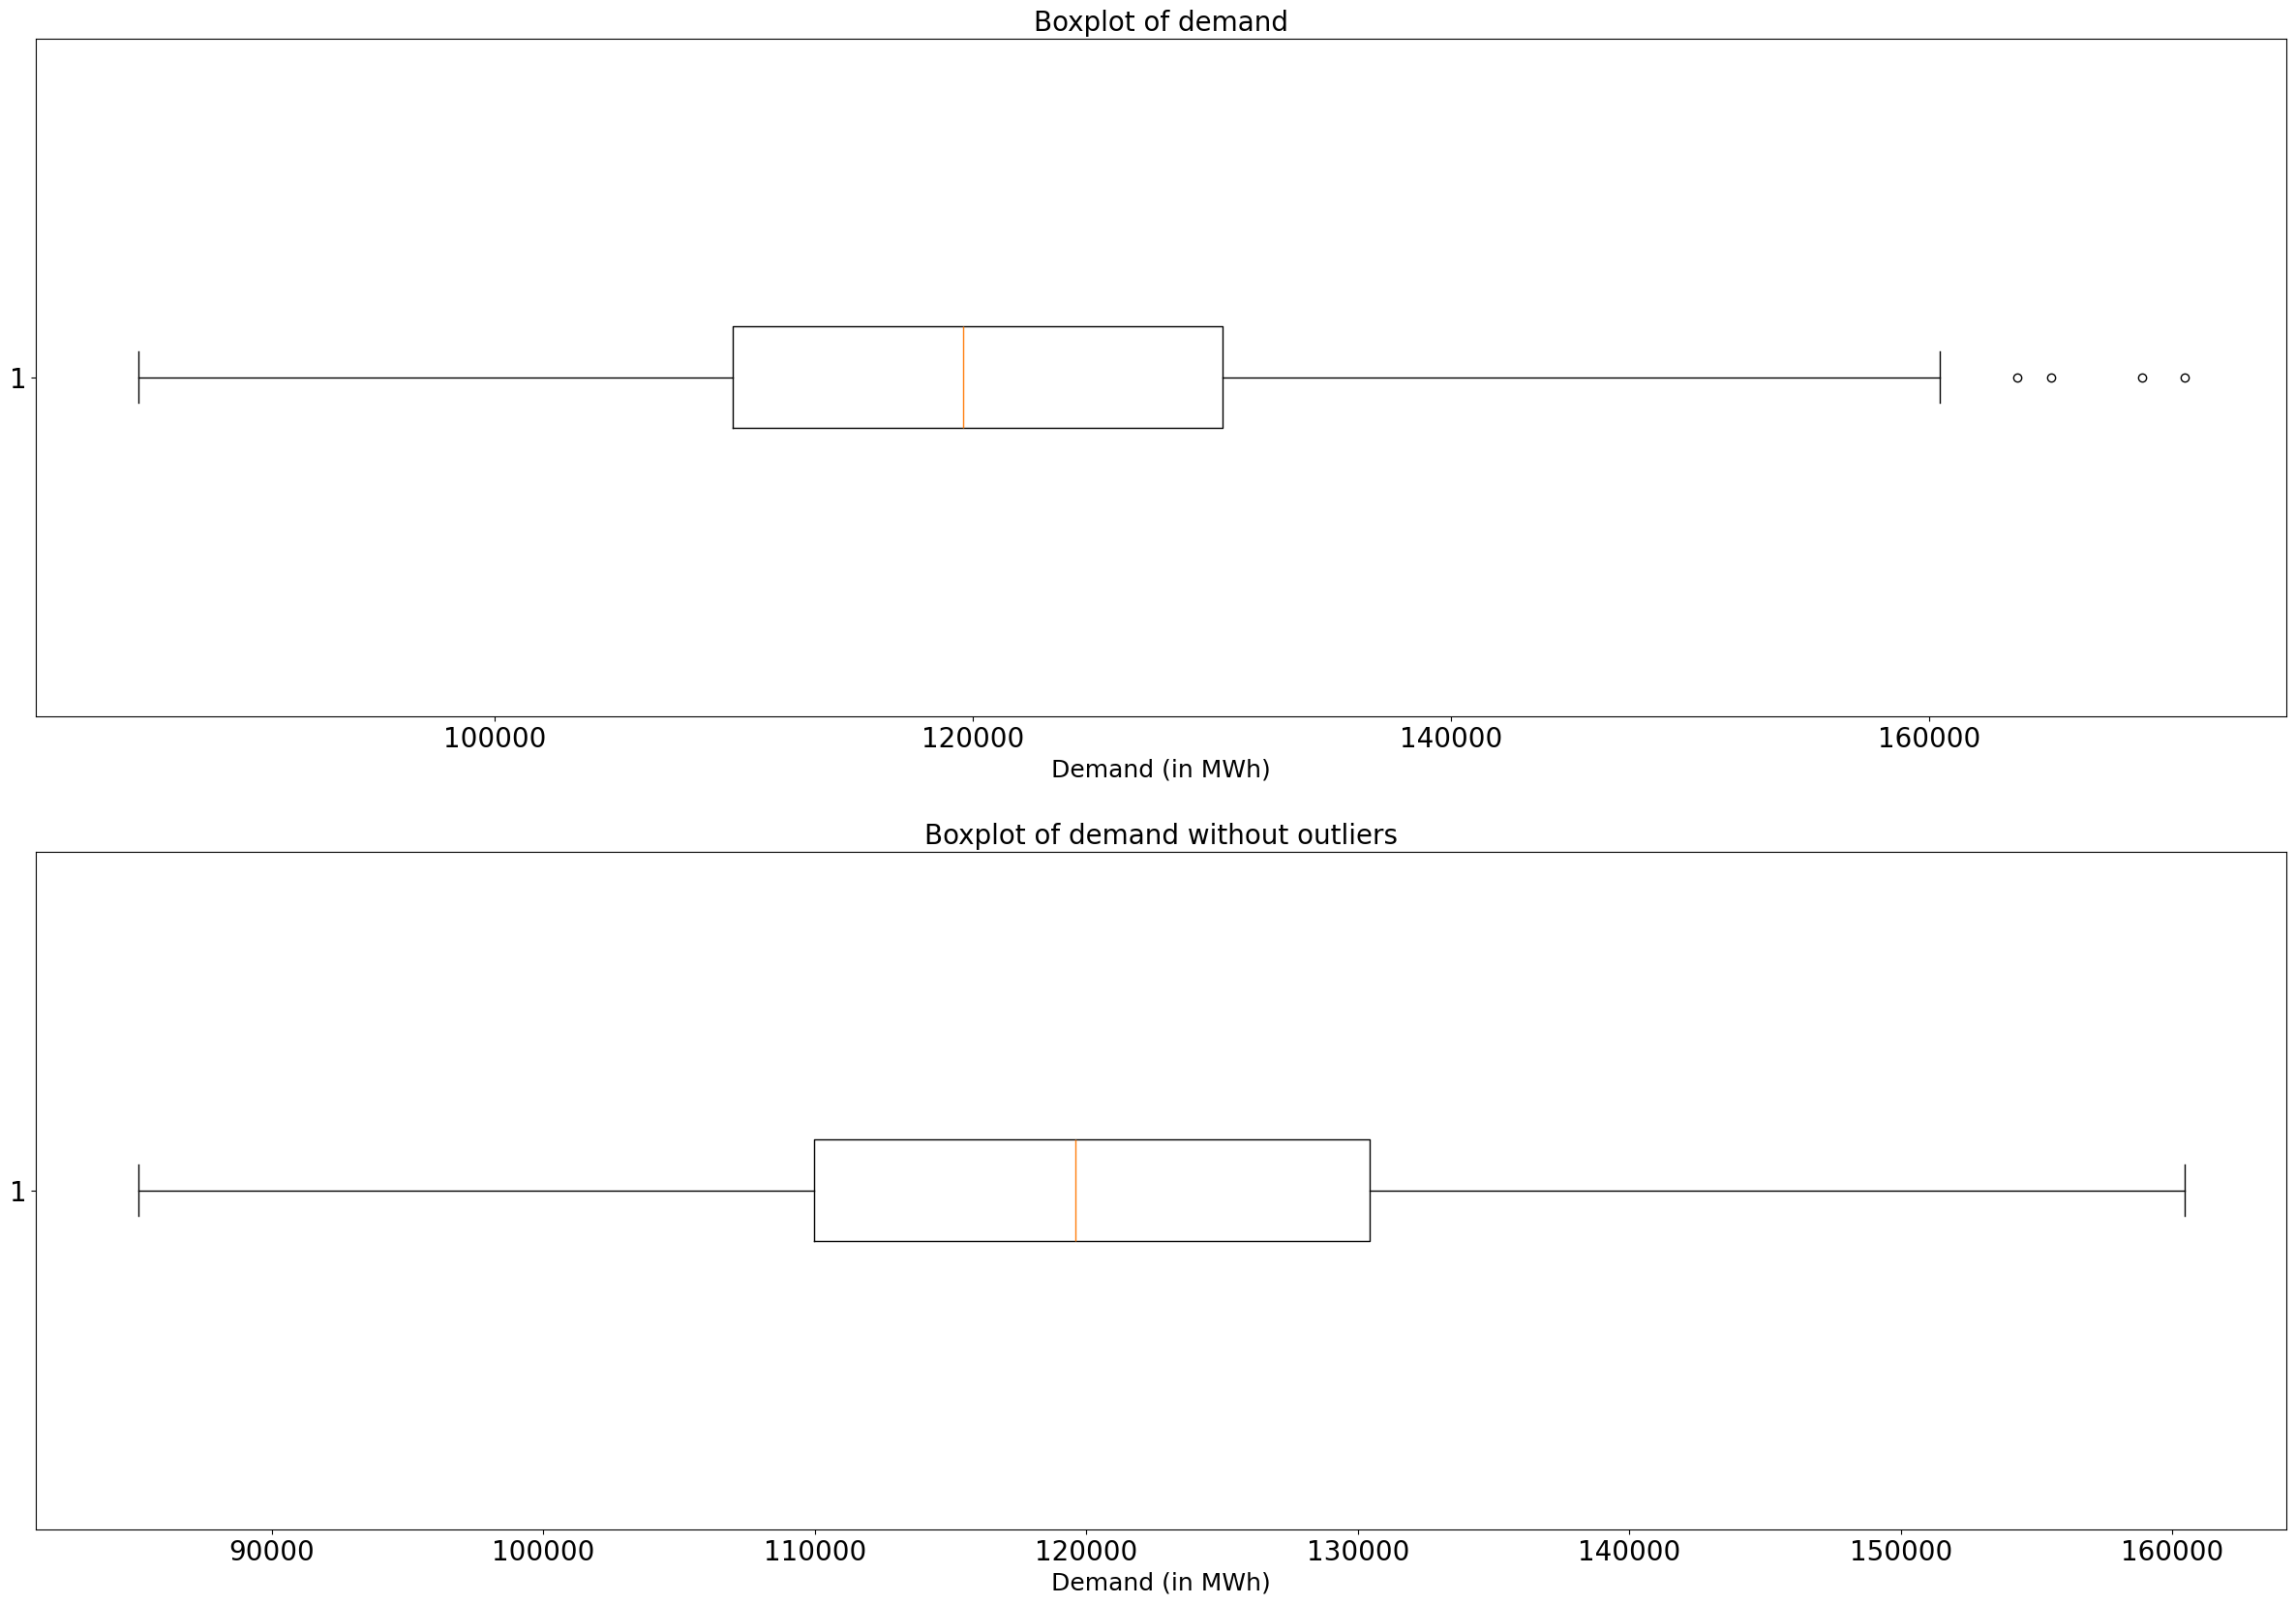

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (30, 20))
ax[0].boxplot(demand_dataset['demand'], vert = False)
ax[0].tick_params(labelsize=20)
ax[0].set_title('Boxplot of demand', size = 20)
ax[0].set_xlabel("Demand (in MWh)", fontsize = 18)

ax[1].boxplot(demand_dataset['demand'], vert = False, showfliers= False)
ax[1].tick_params(labelsize=20)
ax[1].set_title("Boxplot of demand without outliers", size = 20)
ax[1].set_xlabel("Demand (in MWh)", fontsize = 18)

plt.show()

### Find outlier location

In [22]:
df = demand_dataset.copy()
def findOutlier(column):
    data = np.array(demand_dataset[column])
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    rowWithOutlier = demand_dataset[column].isin(outliers)
    outlierDF = df[rowWithOutlier]
    return outlierDF

featureSelected = ['demand',
                    'RRP',
                    'min_temperature',
                    'max_temperature',
                    'solar_exposure',
                    'rainfall']
for feature in featureSelected:
    outlierdf = findOutlier(feature)
    if outlierdf.empty:
        print("\n\nNo outlier found in feature", feature)
    else:
        print('*'*10 ,f'In feature {feature}, here are the outliers:\n\n', findOutlier(feature))


********** In feature demand, here are the outliers:

                 demand          RRP  demand_pos_RRP  RRP_positive  \
date                                                                
2018-01-19  165070.595   647.574163      165070.595    647.574163   
2019-01-25  168894.845   906.437232      168894.845    906.437232   
2019-03-01  163682.040  1284.799876      163682.040   1284.799876   
2020-01-31  170653.840  2809.437516      170653.840   2809.437516   

            demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
date                                                                         
2018-01-19             0.0           0.0              0.0             22.5   
2019-01-25             0.0           0.0              0.0             21.1   
2019-03-01             0.0           0.0              0.0             22.6   
2020-01-31             0.0           0.0              0.0             21.5   

            max_temperature  solar_exposure  rainfall  school

Outlier intersection

In [23]:
outlierDF = findOutlier('demand')
demandOutIndex = outlierDF.index.to_list()
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
for feature in featureSelected:
    indexToCompare = findOutlier(feature).index.to_list()
    print(f'intersection of outlier for demand and {feature} is: '
          , intersection(indexToCompare, demandOutIndex))

intersection of outlier for demand and demand is:  ['2018-01-19', '2019-01-25', '2019-03-01', '2020-01-31']
intersection of outlier for demand and RRP is:  ['2018-01-19', '2019-01-25', '2019-03-01', '2020-01-31']
intersection of outlier for demand and min_temperature is:  []
intersection of outlier for demand and max_temperature is:  ['2018-01-19', '2019-01-25', '2019-03-01', '2020-01-31']
intersection of outlier for demand and solar_exposure is:  []
intersection of outlier for demand and rainfall is:  []


### Average demand per weekday and month of year

In [24]:
# Create day month year variable
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year 
df['month'] = df['date'].dt.month 
df['day'] = df['date'].dt.day
df['dayOfWeek'] = df['date'].dt.dayofweek

fig, axs = plt.subplots(2, 1, figsize=(12,12))
fig.tight_layout(pad=5)
ave_demand_month = df.groupby(['month', 'year'])['demand'].mean().reset_index()
monthPlot = sns.lineplot(ave_demand_month, x="month", y="demand", hue='year', palette=sns.color_palette("husl", 6), errorbar=('ci',False), ax=axs[0])
monthPlot.set_title('Average demand group by month and day of week', fontsize=22)
monthPlot.set_xlabel('Month', fontsize = 20)
monthPlot.set_xticks(range(1, 13))
monthPlot.set_ylabel('Average Demand', fontsize=20)
monthPlot.tick_params(labelsize = 20)
monthPlot.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 20)
monthPlot.tick_params(axis='y', labelsize = 20)
monthPlot.legend(loc = 'upper right', fontsize=13)

ave_demand_day = df.groupby(['dayOfWeek', 'year'])['demand'].mean().reset_index()
print(ave_demand_day)
dayPlot = sns.lineplot(ave_demand_day, x="dayOfWeek", y="demand", hue='year', palette=sns.color_palette("husl", 6), errorbar=('ci',False), ax=axs[1])
# dayPlot.set_title('Average demand of each year in weekday', fontsize=15)
dayPlot.set_xticks(range(0,7))
dayPlot.tick_params(labelsize = 20)
dayPlot.set_xlabel('Weekday', fontsize = 20)
dayPlot.set_ylabel('Aveage Demand', fontsize=20)
dayPlot.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize = 20)
dayPlot.tick_params(axis='y', labelsize = 20)
dayPlot.legend(loc = 'upper right', fontsize=13)
plt.show()

KeyError: 'date'